# Section 1: Libraries

In [6]:
import pandas as pd # Data manipulation and analysis
import matplotlib.pyplot as plt # Data manipulation and visualization
import numpy as np # Data manipulation and visualization
from sklearn.ensemble import RandomForestRegressor # Random Forest Regressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # evaluation metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate # Model selection and evaluation
import warnings
warnings.filterwarnings('ignore') # Ignore warnings

# Section 2: Import Data

In [ ]:
ds = r"C:\Users\ASUSROG\Desktop\TECHBROS\crime_dataset.csv"  # Use raw string for Windows path 
df = pd.read_csv(ds) # DO NOT FORGET TO CHANGE THE PATH OF THE DATASET

print(f"Dataset loaded successfully with shape: {df.shape}")
print("\nDataset info:")
df.info()

Dataset loaded successfully with shape: (354242, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354242 entries, 0 to 354241
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   unique_key            354242 non-null  int64  
 1   date                  354242 non-null  object 
 2   primary_type          354242 non-null  object 
 3   description           354242 non-null  object 
 4   location_description  354242 non-null  object 
 5   latitude              354242 non-null  float64
 6   longitude             354242 non-null  float64
 7   location              354242 non-null  object 
 8   weight                354242 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 24.3+ MB


# Section 3: Data check (null value?)

In [8]:
print(f"\nNull values check:")
print(df.isna().sum())  # Data is clean, no null values


Null values check:
unique_key              0
date                    0
primary_type            0
description             0
location_description    0
latitude                0
longitude               0
location                0
weight                  0
dtype: int64


# Section 4: Preprocess

In [9]:
def preprocess(df):
    """Enhanced preprocessing function with error handling"""
    print("Starting preprocessing...")
    
    # Convert date with better error handling
    df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True) # Convert date to datetime with UTC
    df.shape 
    # Extract time features
    df['year'] = df['date'].dt.year # Extract year from date
    df['month'] = df['date'].dt.month # Extract month from date
    df['day'] = df['date'].dt.day # Extract day from date
    df['hour'] = df['date'].dt.hour # Extract hour from date

    # Add day/night feature
    df['time_of_day'] = df['hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
    
    # Add circular time features for better representation
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24) 
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    print(f"Time features created. Dataset shape: {df.shape}")
    
    # One-hot encoding for categorical variables
    categorical_cols = ['location_description', 'primary_type', 'description']
    print(f"Applying one-hot encoding to: {categorical_cols}")
    
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    print(f"Preprocessing completed. Final dataset shape: {df.shape}")
    return df

df_processed = preprocess(df.copy())

Starting preprocessing...
Time features created. Dataset shape: (354242, 18)
Applying one-hot encoding to: ['location_description', 'primary_type', 'description']
Preprocessing completed. Final dataset shape: (354242, 118)


# Section 5: Enhanced Training with Cross-Validation

In [10]:
print("\n" + "="*60)
print("MACHINE LEARNING MODEL WITH CROSS-VALIDATION")
print("="*60)

# Prepare features and target
X = df_processed.drop(['date', 'latitude', 'longitude', 'location', 'weight', 'unique_key', 'time_of_day'], axis=1, errors='ignore')
y = df_processed['weight']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Number of features: {len(X.columns)}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Initialize the model
model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    max_depth=10,
    n_jobs=-1  # Use all available cores
)

print(f"\nModel initialized: {model}")

# Cross-Validation Setup
print("\n🔄 CROSS-VALIDATION ANALYSIS")
print("-" * 40)

# Define cross-validation strategy
cv_folds = 5  # 5-fold cross-validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Define scoring metrics for cross-validation
scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

print(f"Performing {cv_folds}-fold cross-validation...")
print("This may take a few minutes...")

# Perform cross-validation
cv_results = cross_validate(
    model, X_train, y_train, 
    cv=kf, 
    scoring=scoring_metrics,
    return_train_score=True,
    n_jobs=-1
)

# Calculate and display cross-validation results
print(f"\n📊 CROSS-VALIDATION RESULTS:")
print("-" * 40)

# R² Score
r2_scores = cv_results['test_r2']
print(f"R² Score - Mean: {r2_scores.mean():.4f} (±{r2_scores.std()*2:.4f})")
print(f"R² Score - Individual folds: {[f'{score:.4f}' for score in r2_scores]}")

# RMSE (convert from negative MSE)
mse_scores = -cv_results['test_neg_mean_squared_error']
rmse_scores = np.sqrt(mse_scores)
print(f"RMSE - Mean: {rmse_scores.mean():.4f} (±{rmse_scores.std()*2:.4f})")
print(f"RMSE - Individual folds: {[f'{score:.4f}' for score in rmse_scores]}")

# MAE
mae_scores = -cv_results['test_neg_mean_absolute_error']
print(f"MAE - Mean: {mae_scores.mean():.4f} (±{mae_scores.std()*2:.4f})")
print(f"MAE - Individual folds: {[f'{score:.4f}' for score in mae_scores]}")

# Train the final model on full training set
print(f"\n🏋️ FINAL MODEL TRAINING")
print("-" * 30)
print('Training final model on full training set...')

model.fit(X_train, y_train)
print('Training completed successfully!')

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate final test metrics
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print(f"\n🎯 FINAL TEST SET PERFORMANCE:")
print("-" * 35)
print(f"RMSE: {final_rmse:.4f}")
print(f"R² Score: {final_r2:.4f} ({final_r2:.2%})")
print(f"MAE: {final_mae:.4f}")

# Compare CV results with final test results
print(f"\n📈 CROSS-VALIDATION vs TEST SET COMPARISON:")
print("-" * 45)
print(f"{'Metric':<10} {'CV Mean':<15} {'Test Set':<15} {'Difference':<15}")
print("-" * 60)
print(f"{'R²':<10} {r2_scores.mean():<15.4f} {final_r2:<15.4f} {abs(r2_scores.mean()-final_r2):<15.4f}")
print(f"{'RMSE':<10} {rmse_scores.mean():<15.4f} {final_rmse:<15.4f} {abs(rmse_scores.mean()-final_rmse):<15.4f}")
print(f"{'MAE':<10} {mae_scores.mean():<15.4f} {final_mae:<15.4f} {abs(mae_scores.mean()-final_mae):<15.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🌟 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 40)
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature'][:35]:<35} {row['importance']:.4f}")

# Model stability analysis
print(f"\n🔍 MODEL STABILITY ANALYSIS:")
print("-" * 30)
cv_std_r2 = r2_scores.std()
cv_range_r2 = r2_scores.max() - r2_scores.min()

if cv_std_r2 < 0.02:
    stability = "Very Stable"
elif cv_std_r2 < 0.05:
    stability = "Stable"
elif cv_std_r2 < 0.1:
    stability = "Moderately Stable"
else:
    stability = "Unstable"

print(f"R² Standard Deviation: {cv_std_r2:.4f}")
print(f"R² Range (max-min): {cv_range_r2:.4f}")
print(f"Model Stability: {stability}")


MACHINE LEARNING MODEL WITH CROSS-VALIDATION

Feature matrix shape: (354242, 111)
Target vector shape: (354242,)
Number of features: 111

Training set shape: (247969, 111)
Test set shape: (106273, 111)

Model initialized: RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

🔄 CROSS-VALIDATION ANALYSIS
----------------------------------------
Performing 5-fold cross-validation...
This may take a few minutes...

📊 CROSS-VALIDATION RESULTS:
----------------------------------------
R² Score - Mean: 0.9472 (±0.0105)
R² Score - Individual folds: ['0.9498', '0.9468', '0.9539', '0.9473', '0.9380']
RMSE - Mean: 3.2232 (±0.3038)
RMSE - Individual folds: ['3.1265', '3.2392', '3.0356', '3.2258', '3.4888']
MAE - Mean: 1.0156 (±0.0839)
MAE - Individual folds: ['0.9862', '0.9762', '0.9863', '1.0456', '1.0837']

🏋️ FINAL MODEL TRAINING
------------------------------
Training final model on full training set...
Training completed successfully!

🎯 FINAL TEST SET PERFORMANCE:
---------------

# Section 6: Location-based Analysis with Cross-Validation Results

In [ ]:
# Recreate original dataframe for location analysis
df_original = pd.read_csv(ds)
location_translations = {
    'ABANDONED BUILDING': 'TERK EDİLMİŞ BİNA',
    'AIRPORT/AIRCRAFT': 'HAVALİMANI/UÇAK',
    'ALLEY': 'ARA SOKAK',
    'ATHLETIC CLUB': 'SPOR KULÜBÜ',
    'ATM (AUTOMATIC TELLER MACHINE)': 'ATM (BANKA OTOMATİK VEZNESİ)',
    'BANK': 'BANKA',
    'BAR OR TAVERN': 'BAR VEYA MEYHANE',
    'BARBERSHOP': 'BERBER DÜKKANI',
    'CAR WASH': 'ARABA YIKAMA',
    'CHA PARKING LOT/GROUNDS': 'SOSYAL KONUT OTOPARKI/ALANI',
    'CHURCH/SYNAGOGUE/PLACE OF WORSHIP': 'İBADETHANE',
    'CONSTRUCTION SITE': 'İNŞAAT ALANI',
    'CONVENIENCE STORE': 'BAKKAL/MARKET',
    'CTA BUS': 'TOPLU TAŞIMA OTOBÜSÜ',
    'CTA BUS STOP': 'OTOBÜS DURAĞI',
    'CTA PLATFORM': 'TOPLU TAŞIMA PLATFORMU',
    'CTA STATION': 'TOPLU TAŞIMA İSTASYONU',
    'CTA TRAIN': 'TOPLU TAŞIMA TRENİ',
    'CURRENCY EXCHANGE': 'DÖVİZ BÜROSU',
    'DEPARTMENT STORE': 'ALIŞVERİŞ MERKEZİ',
    'DRUG STORE': 'ECZANE',
    'FACTORY/MANUFACTURING BUILDING': 'FABRİKA/ÜRETİM TESİSİ',
    'GAS STATION': 'BENZİN İSTASYONU',
    'GOVERNMENT BUILDING/PROPERTY': 'DEVLET BİNASI/MÜLKİYETİ',
    'GROCERY FOOD STORE': 'MARKET',
    'HOSPITAL BUILDING/GROUNDS': 'HASTANE BİNASI/ALANI',
    'LAKEFRONT/WATERFRONT/RIVERBANK': 'GÖL/DENİZ/NEHİR KENARI',
    'LIBRARY': 'KÜTÜPHANE',
    'MOVIE HOUSE/THEATER': 'SİNEMA/TİYATRO',
    'PARK PROPERTY': 'PARK ALANI',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)': 'OTOPARK (TİCARİ)',
    'PARKING LOT/GARAGE(NON.RESID.)': 'OTOPARK (TİCARİ)',
    'POLICE FACILITY/VEH PARKING LOT': 'POLİS TESİSİ/OTOPARKI',
    'RESTAURANT': 'RESTORAN',
    'SCHOOL, PUBLIC, BUILDING': 'DEVLET OKULU BİNASI',
    'SIDEWALK': 'KALDIRIM',
    'SMALL RETAIL STORE': 'KÜÇÜK PERAKENDE MAĞAZA',
    'SPORTS ARENA/STADIUM': 'SPOR ARENA/STADYUM',
    'STREET': 'SOKAK',
    'TAVERN/LIQUOR STORE': 'MEYHANE/İÇKİ DÜKKANI',
    'TAXICAB': 'TAKSİ',
    'VACANT LOT/LAND': 'BOŞ ARSA/ARAZİ',
    'VEHICLE-COMMERCIAL': 'TİCARİ ARAÇ'
} # Translations for location descriptions, TR version

df_original['hour'] = pd.to_datetime(df_original['date']).dt.hour
df_original['time_of_day'] = df_original['hour'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
df_original['location_description'] = df_original['location_description'].map(
    lambda x: location_translations.get(x, x)
) # DO NOT FORGET TO REMOVE TRANSLATED LOCATIONS FOR ENGLISH VERSION
location_descriptions = df_original['location_description']
time_of_day = df_original['time_of_day']
location_test = location_descriptions.iloc[X_test.index]
time_test = time_of_day.iloc[X_test.index]

# Create results dataframe with time_of_day
results_df = pd.DataFrame({
    'actual_weight': y_test.values,
    'predicted_weight': y_pred,
    'location_description': location_test.values,
    'time_of_day': time_test.values,
    'prediction_error': np.abs(y_test.values - y_pred)
})

# Calculate location-based statistics with day/night split
location_stats = results_df.groupby(['location_description', 'time_of_day']).agg({
    'predicted_weight': ['mean', 'count', 'std'],
    'actual_weight': 'mean',
    'prediction_error': 'mean'
}).round(4)

# Flatten column names
location_stats.columns = ['pred_mean', 'count', 'pred_std', 'actual_mean', 'avg_error']
location_stats = location_stats.reset_index()

# Calculate day/night difference
pivot_stats = location_stats.pivot(
    index='location_description', 
    columns='time_of_day', 
    values=['pred_mean', 'count']
).fillna(0)

# Flatten column names and calculate difference
pivot_stats.columns = [f'{col[0]}_{col[1]}' for col in pivot_stats.columns]
pivot_stats['risk_difference'] = pivot_stats['pred_mean_Night'] - pivot_stats['pred_mean_Day']
pivot_stats = pivot_stats.reset_index()

# Filter locations with sufficient samples (≥10 in both day and night)
significant_locations = pivot_stats[
    (pivot_stats['count_Day'] >= 10) & 
    (pivot_stats['count_Night'] >= 10)
].copy()

# Section 6B: Day/Night Analysis Display

In [12]:
print("\n🌓 DAY/NIGHT RISK ANALYSIS:")
print("-" * 40)
print(f"Locations with ≥10 samples in both day and night: {len(significant_locations)}")

# Sort by night risk
night_risk = significant_locations.sort_values('pred_mean_Night', ascending=False)
print(f"\n🌙 TOP 5 HIGHEST RISK LOCATIONS AT NIGHT:")
for i, row in night_risk.head().iterrows():
    print(f"{i+1:2d}. {row['location_description'][:40]:<43}")
    print(f"    Night Risk: {row['pred_mean_Night']:.4f}")
    print(f"    Day Risk: {row['pred_mean_Day']:.4f}")
    print(f"    Difference: {row['risk_difference']:.4f}")

# Sort by risk difference
risk_diff = significant_locations.sort_values('risk_difference', ascending=False)
print(f"\n📊 TOP 5 LOCATIONS WITH HIGHEST NIGHT/DAY RISK DIFFERENCE:")
for i, row in risk_diff.head().iterrows():
    print(f"{i+1:2d}. {row['location_description'][:40]:<43}")
    print(f"    Risk Difference: {row['risk_difference']:.4f}")
    print(f"    Night Risk: {row['pred_mean_Night']:.4f}")
    print(f"    Day Risk: {row['pred_mean_Day']:.4f}")


🌓 DAY/NIGHT RISK ANALYSIS:
----------------------------------------
Locations with ≥10 samples in both day and night: 42

🌙 TOP 5 HIGHEST RISK LOCATIONS AT NIGHT:
19. KALDIRIM                                   
    Night Risk: 60.5596
    Day Risk: 56.4660
    Difference: 4.0936
 2. ARA SOKAK                                  
    Night Risk: 59.3151
    Day Risk: 57.8521
    Difference: 1.4630
30. SOSYAL KONUT OTOPARKI/ALANI                
    Night Risk: 59.2777
    Day Risk: 55.9183
    Difference: 3.3594
27. POLİS TESİSİ/OTOPARKI                      
    Night Risk: 58.2932
    Day Risk: 60.4964
    Difference: -2.2032
11. DEVLET BİNASI/MÜLKİYETİ                    
    Night Risk: 57.0637
    Day Risk: 53.5821
    Difference: 3.4816

📊 TOP 5 LOCATIONS WITH HIGHEST NIGHT/DAY RISK DIFFERENCE:
16. GÖL/DENİZ/NEHİR KENARI                     
    Risk Difference: 7.2441
    Night Risk: 52.4071
    Day Risk: 45.1630
 3. ARABA YIKAMA                               
    Risk Difference: 

# Section 7: Enhanced Visualization

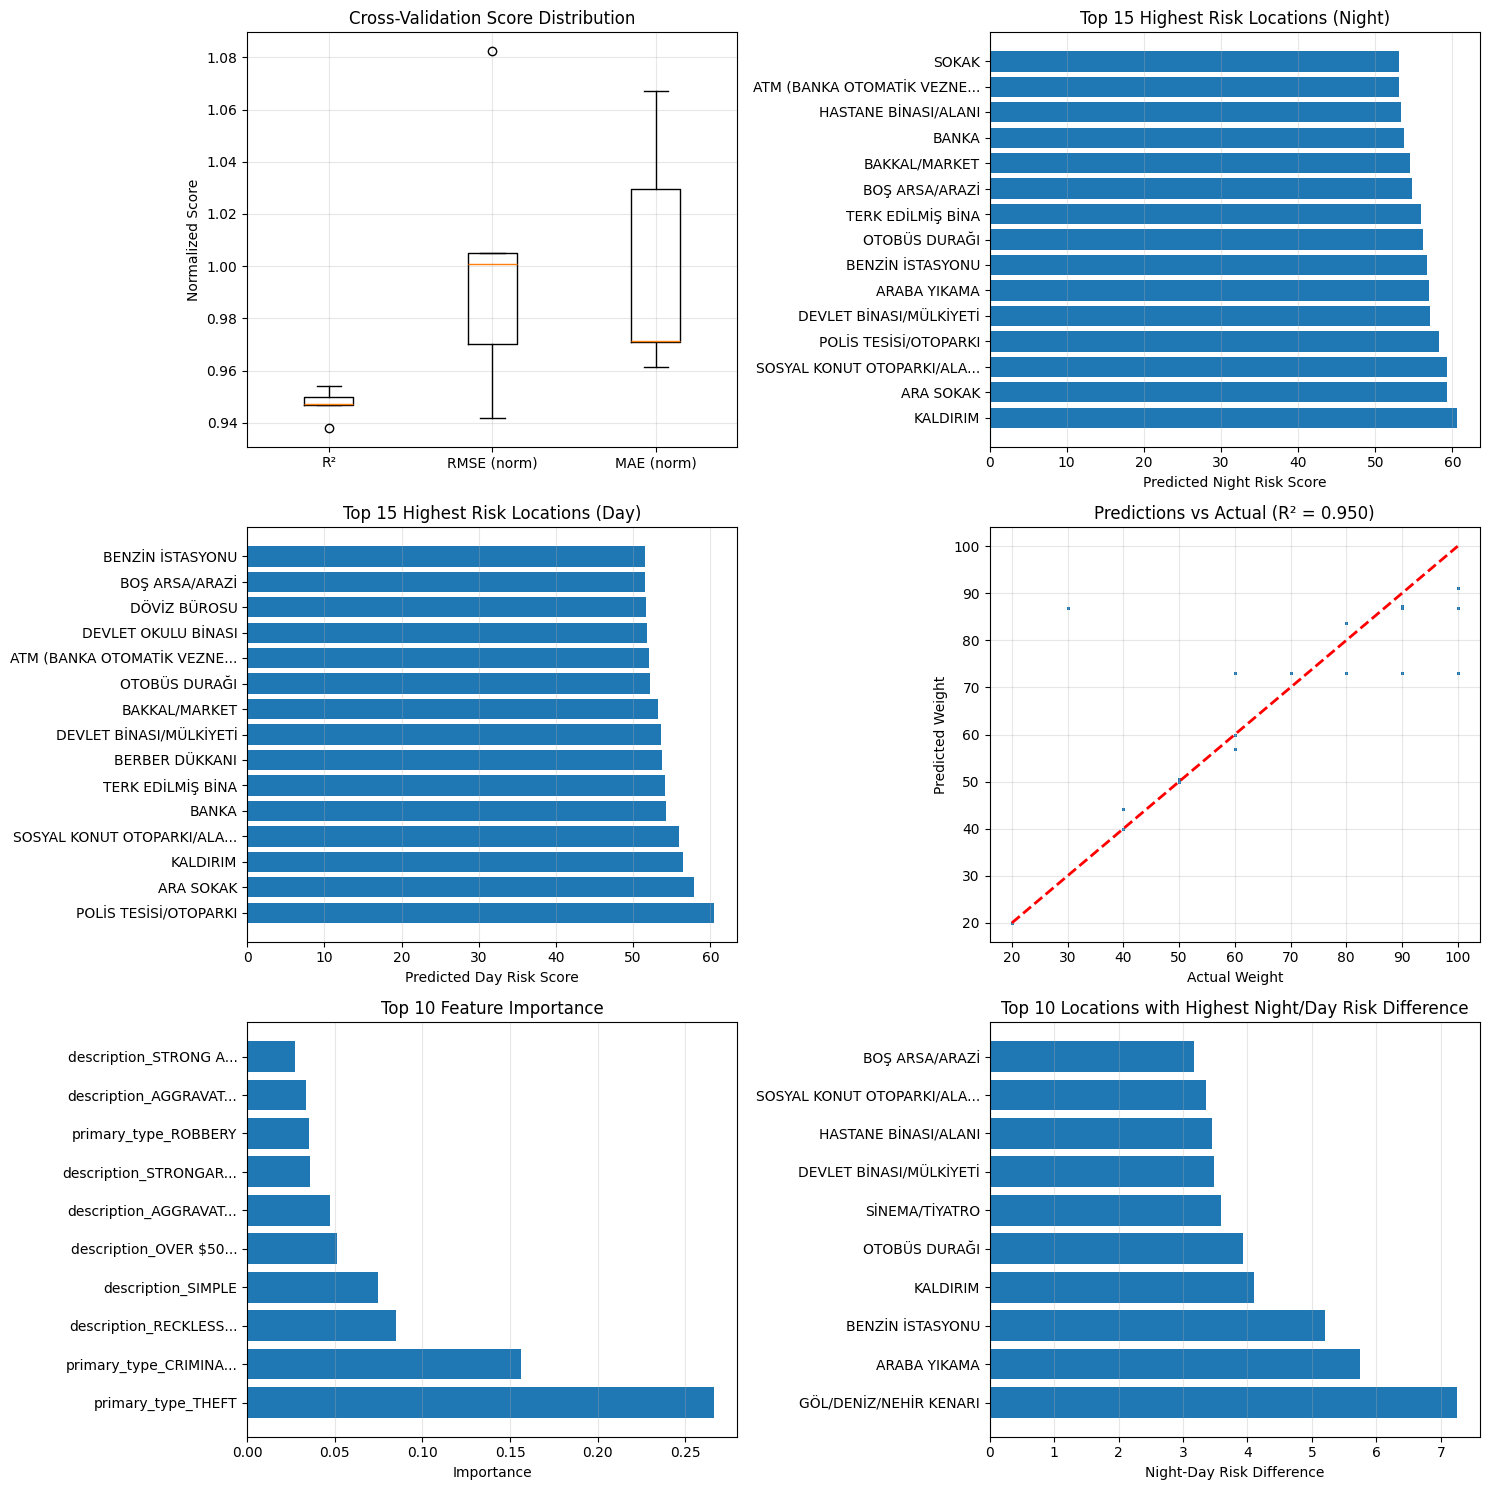

In [13]:
# Plot 1: Cross-validation scores
plt.figure(figsize=(15, 15))  # Increased height for better visibility
plt.subplot(3, 2, 1)
plt.boxplot([r2_scores, rmse_scores/rmse_scores.mean(), mae_scores/mae_scores.mean()], 
            labels=['R²', 'RMSE (norm)', 'MAE (norm)'])
plt.title('Cross-Validation Score Distribution')
plt.ylabel('Normalized Score')
plt.grid(True, alpha=0.3)

# Plot 2: Top 15 risky locations at night
plt.subplot(3, 2, 2)
top_15_night = significant_locations.nlargest(15, 'pred_mean_Night')
plt.barh(range(len(top_15_night)), top_15_night['pred_mean_Night'])
plt.yticks(range(len(top_15_night)), [loc[:25] + "..." if len(loc) > 25 else loc for loc in top_15_night['location_description']])
plt.xlabel('Predicted Night Risk Score')
plt.title('Top 15 Highest Risk Locations (Night)')
plt.grid(axis='x', alpha=0.3)

# Plot 3: Top 15 risky locations during day (New)
plt.subplot(3, 2, 3)
top_15_day = significant_locations.nlargest(15, 'pred_mean_Day')
plt.barh(range(len(top_15_day)), top_15_day['pred_mean_Day'])
plt.yticks(range(len(top_15_day)), [loc[:25] + "..." if len(loc) > 25 else loc for loc in top_15_day['location_description']])
plt.xlabel('Predicted Day Risk Score')
plt.title('Top 15 Highest Risk Locations (Day)')
plt.grid(axis='x', alpha=0.3)

# Plot 4: Prediction vs Actual scatter plot
plt.subplot(3, 2, 4)
plt.scatter(y_test, y_pred, alpha=0.5, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title(f'Predictions vs Actual (R² = {final_r2:.3f})')
plt.grid(True, alpha=0.3)

# Plot 5: Feature importance
plt.subplot(3, 2, 5)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), [f[:20] + "..." if len(f) > 20 else f for f in top_features['feature']])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.grid(axis='x', alpha=0.3)

# Plot 6: Day vs Night Risk Comparison (New)
plt.subplot(3, 2, 6)
top_10_diff = significant_locations.nlargest(10, 'risk_difference')
plt.barh(range(len(top_10_diff)), top_10_diff['risk_difference'])
plt.yticks(range(len(top_10_diff)), [loc[:25] + "..." if len(loc) > 25 else loc for loc in top_10_diff['location_description']])
plt.xlabel('Night-Day Risk Difference')
plt.title('Top 10 Locations with Highest Night/Day Risk Difference')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Section 8: Export Data

In [20]:
# Export location-based statistics with day/night split
location_stats.to_csv(r"C:\Users\ASUSROG\Desktop\location_risk_stats_day_night_tr.csv", index=False)

# Export significant locations with day/night comparison
significant_locations.to_csv(r"C:\Users\ASUSROG\Desktop\significant_locations_day_night_tr.csv", index=False)